In [1]:
import os
import cv2
import shutil
import zipfile
import numpy as np
from tqdm import tqdm
import pydicom as dicom
import pydicom.pixel_data_handlers.util as util
import matplotlib.pyplot as plt

In [2]:
from run_digipath_pipeline import TextRedaction, update_headers, save_headers_ascsv
from data_utils import run_digipath_deid, convert_to_1x
script_dir = '/root/apoorva/duke_digipath/'
craft_model_dir = os.path.join(script_dir,'model_weights/craft_models/craft_mlt_25k.pth')
fpr_model_dir = os.path.join(script_dir, 'model_weights/tissue_text_models/v139.pth')

out_dir = '/root/apoorva/sample_digipath/'
batch_size = 16
cuda_bool = False
if cuda_bool is True:
    device='cuda'
else:
    device='cpu'
################################################


In [3]:
#Read an image
image_dirpath = '/DDN_storage/PHI/PHI_staging/'
list_files = os.listdir(image_dirpath)

In [4]:
#Read an image
image_dirpath = '/DDN_storage/PHI/PHI_staging/'
list_files = os.listdir(image_dirpath)

def unzip_folder(zip_path,extract_path):
    with zipfile.ZipFile(zip_path,'r') as zip_ref:
        zip_ref.extractall(extract_path)

def run_deid(series_path):
    text_det = TextRedaction(craft_model_dir, cuda_bool, device, "craft", fpr_model_dir)
    #give a list of headers in a series
    base_dir = series_path
    for files_ in os.listdir(base_dir):
        if 'level-0.dcm' in files_:
            ip_paths=[files_] 
            #ds = dicom.dcmread(series_path+'/'+files_)
            #img = ds.pixel_array
            #print(img.shape)
            #img = convert_to_1x(ds)
            #if ds.PhotometricInterpretation=='YBR_FULL_422':
            #    image = util.convert_color_space(img,"YBR_FULL_422","RGB")
            #else:
             #   image = ds.pixel_array
            #cv2.imwrite('/root/apoorva/'+files_.split('/')[-1].replace('.dcm','.jpeg'),image)
    
    headers = run_digipath_deid(ip_paths, base_dir)
    ########################################################
    digipath_headers,bboxes = text_det.run_textredaction(headers, batch_size)
    #imag = img[np.newaxis,:,:,:]
    #print(detector(imag))
    #print(bboxes)
    #if len(bboxes[0])>0:
    #    for box in bboxes[0]:
    #        cv2.rectangle(img,(int(box.y),int(box.x)),(int(box.y+box.h),int(box.x+box.w)),(0,255,0),2)
    #plt.imshow(img)

   # cv2.imwrite('/root/apoorva/jpegs/'+ip_paths[0].split('/')[-1].replace('.dcm','.jpeg'),image)
    
    updated_headers = update_headers(digipath_headers) 
    #print(updated_headers)
    save_headers_ascsv(updated_headers,out_dir)
    return out_dir

In [14]:
from doctr.models import detection_predictor
detector = detection_predictor("db_resnet50",pretrained=True)

In [5]:

import time
%load_ext memory_profiler
extract_time_list,deid_time_list,end_to_end_timelist = [],[],[]
for each_study in tqdm(list_files[0:5000]):
    #print(image_dirpath+each_study)
    start_time = time.time()
    all_files = (os.listdir(image_dirpath+each_study))
    each_series = each_study+'.zip'
    zip_file_path = image_dirpath+each_study+'/'+each_series
    extracted_folder_path = '/root/apoorva/sample_digipath/'
    unzip_folder(zip_file_path,extracted_folder_path)
    ext_time = time.time()
    extract_time_list.append(ext_time-start_time)
    ##########Series Extracted
    series_path = extracted_folder_path+each_series.split('.zip')[0]
    run_deid(series_path+'/')
    deid_time_list.append(time.time()-ext_time)
    end_to_end_timelist.append(time.time()-start_time)
    shutil.rmtree(series_path)

  0%|          | 0/4999 [00:00<?, ?it/s]

/root/apoorva/digipath/lib64/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/apoorva/digipath/lib64/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
  0%|          | 10/4999 [02:38<21:56:42, 15.84s/it]


KeyboardInterrupt: 

In [7]:
np.average(extract_time_list),np.average(deid_time_list)

(3.764019451591758, 22.49338714714168)

In [15]:
import pandas as pd
df = pd.read_csv('/root/apoorva/sample_digipath/output.csv')

In [16]:
df['keep_dicom'].value_counts()

keep_dicom
False    5866
True     2909
Name: count, dtype: int64

  0%|          | 0/1 [00:00<?, ?it/s]

(64896, 256, 256, 3)


100%|██████████| 1/1 [00:58<00:00, 58.38s/it]

time taken 11.751431226730347


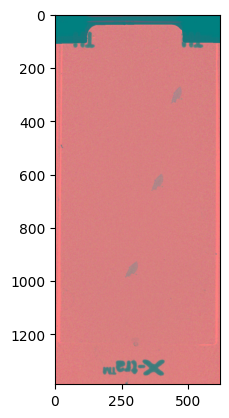

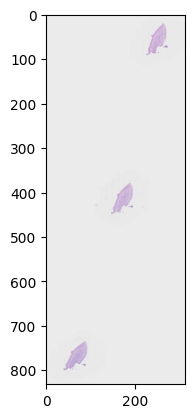

In [10]:
for each_study in tqdm(list_files[2:3]):
    all_files = (os.listdir(image_dirpath+each_study))
    each_series = each_study+'.zip'
    zip_file_path = image_dirpath+each_study+'/'+each_series
    extracted_folder_path = '/root/apoorva/sample_digipath/'
    unzip_folder(zip_file_path,extracted_folder_path)
    series_path = extracted_folder_path+each_series.split('.zip')[0]
    for files_ in os.listdir(series_path):
        if 'level-0.dcm' in files_:
            ip_paths=[files_] 
            import time 
            ds = dicom.dcmread(series_path+'/'+files_)
            print(ds.pixel_array.shape)
            start_time=time.time()
            img = convert_to_1x(ds)
            print('time taken', time.time()-start_time)
            plt.figure()
            plt.imshow(img)
        elif 'macro.dcm'in files_:
            ds = dicom.dcmread(series_path+'/'+files_)
            plt.figure()
            plt.imshow(ds.pixel_array)